In [38]:
# Import required libraries
import pandas as pd
import os

# Define the dataset directory path
DATA_PATH = r"G:\DSP DATA SET"

# Define filenames for all datasets
files = {
    'courses': 'courses.csv',
    'assessments': 'assessments.csv',
    'student_info': 'studentInfo.csv',
    'student_registration': 'studentRegistration.csv',
    'student_assessment': 'studentAssessment.csv',
    'student_vle': 'studentVle.csv',
    'vle': 'vle.csv'
}

# Load all datasets into a dictionary
dfs = {}
for name, filename in files.items():
    file_path = os.path.join(DATA_PATH, filename)
    df = pd.read_csv(file_path)
    dfs[name] = df
    print(f"✅ Loaded '{filename}' with shape {df.shape}")

# Display the basic info and preview of each dataset
for name, df in dfs.items():
    print(f"\n📊 Preview of {name.upper()}:")
    print(df.head(3))
    print("\nData Types and Null Info:")
    print(df.info())


✅ Loaded 'courses.csv' with shape (22, 3)
✅ Loaded 'assessments.csv' with shape (206, 6)
✅ Loaded 'studentInfo.csv' with shape (32593, 12)
✅ Loaded 'studentRegistration.csv' with shape (32593, 5)
✅ Loaded 'studentAssessment.csv' with shape (173912, 5)
✅ Loaded 'studentVle.csv' with shape (10655280, 6)
✅ Loaded 'vle.csv' with shape (6364, 6)

📊 Preview of COURSES:
  code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268

Data Types and Null Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-n

In [39]:
# Extract student background features from studentInfo
student_info = dfs['student_info'].copy()

# Create a binary target column: 1 if Withdrawn, else 0
student_info['target'] = student_info['final_result'].apply(lambda x: 1 if x == 'Withdrawn' else 0)

# Drop final_result to avoid leakage
student_info = student_info.drop(columns=['final_result'])

# Fill missing imd_band with a placeholder
student_info['imd_band'] = student_info['imd_band'].fillna('Unknown')

# Define categorical and numerical columns
categorical_cols = ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability']
numerical_cols = ['num_of_prev_attempts', 'studied_credits']

# One-hot encode categorical variables
student_info_encoded = pd.get_dummies(student_info, columns=categorical_cols, drop_first=True)

print(f"✅ Encoded student_info shape: {student_info_encoded.shape}")
student_info_encoded.head()


✅ Encoded student_info shape: (32593, 36)


,code_module,code_presentation,id_student,num_of_prev_attempts,studied_credits,target,gender_M,region_East Midlands Region,region_Ireland,region_London Region,...,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,imd_band_Unknown,age_band_35-55,age_band_55<=,disability_Y
0,AAA,2013J,11391,0,240,0,True,False,False,False,...,False,False,False,False,False,True,False,False,True,False
1,AAA,2013J,28400,0,60,0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,AAA,2013J,30268,0,60,1,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
3,AAA,2013J,31604,0,60,0,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
4,AAA,2013J,32885,0,60,0,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [40]:
# Define the number of early days
EARLY_DAYS = 28

# Filter studentVle to only include first 28 days
student_vle = dfs['student_vle'].copy()
vle = dfs['vle'].copy()

vle_early = student_vle[student_vle['date'] <= EARLY_DAYS]

# Merge with VLE to get activity_type
vle_early = vle_early.merge(vle[['id_site', 'activity_type']], on='id_site', how='left')

# Total clicks in first 28 days
total_clicks = vle_early.groupby(['code_module', 'code_presentation', 'id_student'])['sum_click'].sum().reset_index()
total_clicks.rename(columns={'sum_click': 'total_clicks_28d'}, inplace=True)

# Active days (number of unique days with any click)
active_days = vle_early.groupby(['code_module', 'code_presentation', 'id_student'])['date'].nunique().reset_index()
active_days.rename(columns={'date': 'active_days_28d'}, inplace=True)

# Optional: Clicks per activity_type (e.g., forum, quiz, oucontent, etc.)
resource_clicks = vle_early.pivot_table(
    index=['code_module', 'code_presentation', 'id_student'],
    columns='activity_type',
    values='sum_click',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Rename resource columns
resource_clicks.columns.name = None
resource_clicks = resource_clicks.rename(columns=lambda x: f'resource_clicks_{x}' if x not in ['code_module', 'code_presentation', 'id_student'] else x)

# Merge all click-related features
click_features = total_clicks.merge(active_days, on=['code_module', 'code_presentation', 'id_student'], how='outer')
click_features = click_features.merge(resource_clicks, on=['code_module', 'code_presentation', 'id_student'], how='outer')

print(f"✅ Click feature shape: {click_features.shape}")
click_features.head()

click_features.to_csv("G:/DSP DATA SET/click_features.csv", index=False)


✅ Click feature shape: (28792, 23)


In [41]:
# Load datasets
assessments = dfs['assessments'].copy()
student_assessment = dfs['student_assessment'].copy()

# Filter assessments assigned within the first 28 days (excluding final exams)
early_assessments = assessments[(assessments['date'] <= EARLY_DAYS) & (assessments['assessment_type'] != 'Exam')]

# Merge student submissions with early assessments
merged_sa = student_assessment.merge(early_assessments[['id_assessment', 'code_module', 'code_presentation']], on='id_assessment', how='inner')

# Mark submission existence
merged_sa['submitted'] = 1

# Aggregate per student
assignment_features = merged_sa.groupby(['code_module', 'code_presentation', 'id_student']).agg(
    num_submitted_early=('submitted', 'count'),
    avg_score_early=('score', 'mean')
).reset_index()

# Get total number of possible early assignments per module/presentation
num_assignments = early_assessments.groupby(['code_module', 'code_presentation'])['id_assessment'].count().reset_index()
num_assignments.rename(columns={'id_assessment': 'num_assignments_early'}, inplace=True)

# Merge total assignment info into student records
assignment_features = assignment_features.merge(num_assignments, on=['code_module', 'code_presentation'], how='left')

# Compute number of missed (not submitted) assignments
assignment_features['num_missed_early'] = assignment_features['num_assignments_early'] - assignment_features['num_submitted_early']

print(f"✅ Assignment feature shape: {assignment_features.shape}")
assignment_features.head()

assignment_features.to_csv("G:/DSP DATA SET/assignment_features.csv", index=False)

✅ Assignment feature shape: (21099, 7)


In [42]:
# First, ensure common keys are ready
join_keys = ['code_module', 'code_presentation', 'id_student']

# Start with background info (includes target label)
df_final = student_info_encoded.copy()

# Merge with click features
df_final = df_final.merge(click_features, on=join_keys, how='left')

# Merge with assignment features
df_final = df_final.merge(assignment_features, on=join_keys, how='left')

# Fill missing values (due to outer joins) with 0 or suitable default
df_final['total_clicks_28d'] = df_final['total_clicks_28d'].fillna(0)
df_final['active_days_28d'] = df_final['active_days_28d'].fillna(0)
df_final['num_submitted_early'] = df_final['num_submitted_early'].fillna(0)
df_final['avg_score_early'] = df_final['avg_score_early'].fillna(0)
df_final['num_assignments_early'] = df_final['num_assignments_early'].fillna(0)
df_final['num_missed_early'] = df_final['num_missed_early'].fillna(0)

# Fill missing resource click types with 0
resource_cols = [col for col in df_final.columns if col.startswith('resource_clicks_')]
df_final[resource_cols] = df_final[resource_cols].fillna(0)

print(f"✅ Final training dataset shape: {df_final.shape}")
df_final.head()

# 保存最终训练数据（包含 SHAP 所需的所有特征）
df_final.to_csv("G:/DSP DATA SET/df_final.csv", index=False)
print("✅ df_final.csv saved.")


✅ Final training dataset shape: (32593, 60)
✅ df_final.csv saved.


In [6]:
from sklearn.model_selection import train_test_split

# Define feature matrix X and target vector y
X = df_final.drop(columns=['target', 'code_module', 'code_presentation', 'id_student'])
y = df_final['target']

# Stratified split to maintain dropout rate distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"✅ X_train shape: {X_train.shape}, y_train mean: {y_train.mean():.4f}")
print(f"✅ X_test shape: {X_test.shape}, y_test mean: {y_test.mean():.4f}")


✅ X_train shape: (22815, 56), y_train mean: 0.3116
✅ X_test shape: (9778, 56), y_test mean: 0.3116


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Initialize Logistic Regression with class_weight
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', random_state=42)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated F1 score
f1_scores = cross_val_score(logreg, X_train, y_train, cv=cv, scoring='f1')
print(f"🔁 CV F1-score (mean): {f1_scores.mean():.4f} | Std: {f1_scores.std():.4f}")

# Train on full training set
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluate
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"\n📊 Logistic Regression Test Set Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Optional: Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


🔁 CV F1-score (mean): 0.5966 | Std: 0.0097

📊 Logistic Regression Test Set Results:
Accuracy: 0.7136
F1-score: 0.6033
AUC: 0.7843

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.78      6731
           1       0.53      0.70      0.60      3047

    accuracy                           0.71      9778
   macro avg       0.69      0.71      0.69      9778
weighted avg       0.74      0.71      0.72      9778

Confusion Matrix:
[[4849 1882]
 [ 918 2129]]


In [8]:
pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"✅ After SMOTE: X_train shape = {X_train_smote.shape}, y distribution: {y_train_smote.value_counts().to_dict()}")

# Initialize Logistic Regression without class_weight
logreg_smote = LogisticRegression(class_weight=None, max_iter=1000, solver='liblinear', random_state=42)

# 5-fold cross-validation on SMOTE data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv_smote = cross_val_score(logreg_smote, X_train_smote, y_train_smote, cv=cv, scoring='f1')
print(f"🔁 SMOTE CV F1-score (mean): {f1_cv_smote.mean():.4f} | Std: {f1_cv_smote.std():.4f}")

# Train on full SMOTE training set
logreg_smote.fit(X_train_smote, y_train_smote)

# Predict on real test set (unchanged)
y_pred_smote = logreg_smote.predict(X_test)
y_proba_smote = logreg_smote.predict_proba(X_test)[:, 1]

# Evaluation
acc = accuracy_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
auc = roc_auc_score(y_test, y_proba_smote)

print(f"\n📊 Logistic Regression with SMOTE - Test Set Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_smote))


✅ After SMOTE: X_train shape = (31412, 56), y distribution: {1: 15706, 0: 15706}
🔁 SMOTE CV F1-score (mean): 0.7870 | Std: 0.0037

📊 Logistic Regression with SMOTE - Test Set Results:
Accuracy: 0.7427
F1-score: 0.5829
AUC: 0.7564

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      6731
           1       0.59      0.58      0.58      3047

    accuracy                           0.74      9778
   macro avg       0.70      0.70      0.70      9778
weighted avg       0.74      0.74      0.74      9778

Confusion Matrix:
[[5504 1227]
 [1289 1758]]


In [11]:
pip install shap

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [18]:
%matplotlib inline


SHAP matrix shape: (9778, 56)


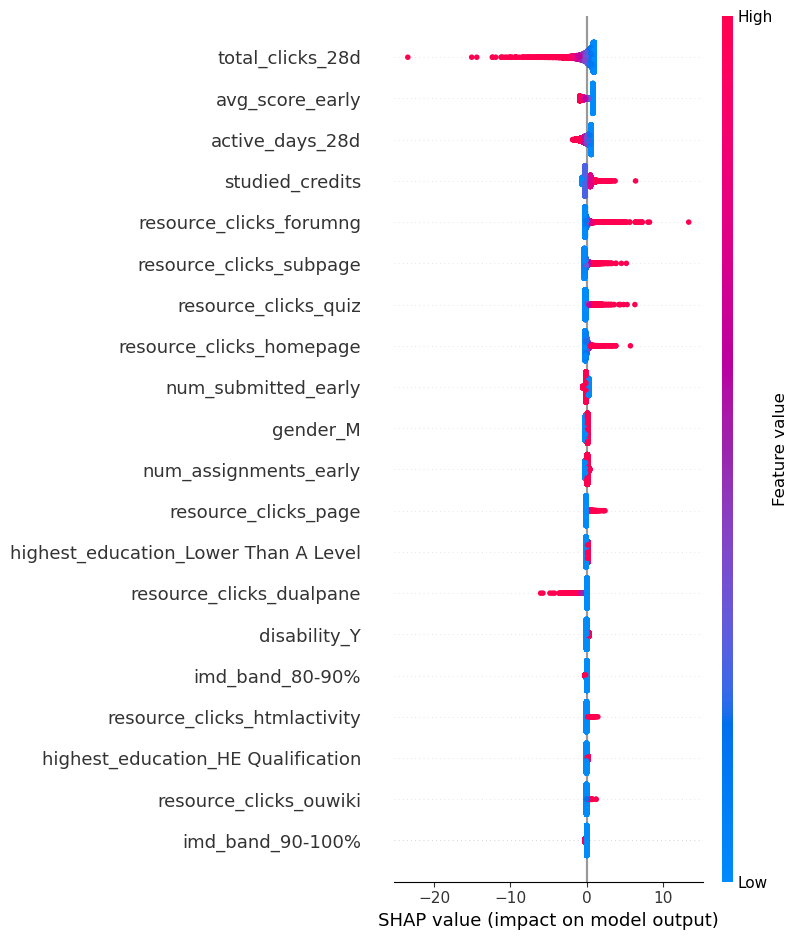

In [20]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure float input
X_train_clean = X_train.astype('float64')
X_test_clean = X_test.astype('float64')

# Use SHAP masker for tabular data
masker = shap.maskers.Independent(X_train_clean)

# Create LinearExplainer with masker
explainer = shap.Explainer(logreg, masker, feature_names=X_train_clean.columns)

# Compute SHAP values
shap_values = explainer(X_test_clean)

# ✅ Extract .values and ensure shape
shap_matrix = shap_values.values  # shape should be (n_samples, n_features)

print("SHAP matrix shape:", shap_matrix.shape)

# Draw summary plot
shap.summary_plot(shap_matrix, X_test_clean)


SHAP matrix shape: (9778, 56)


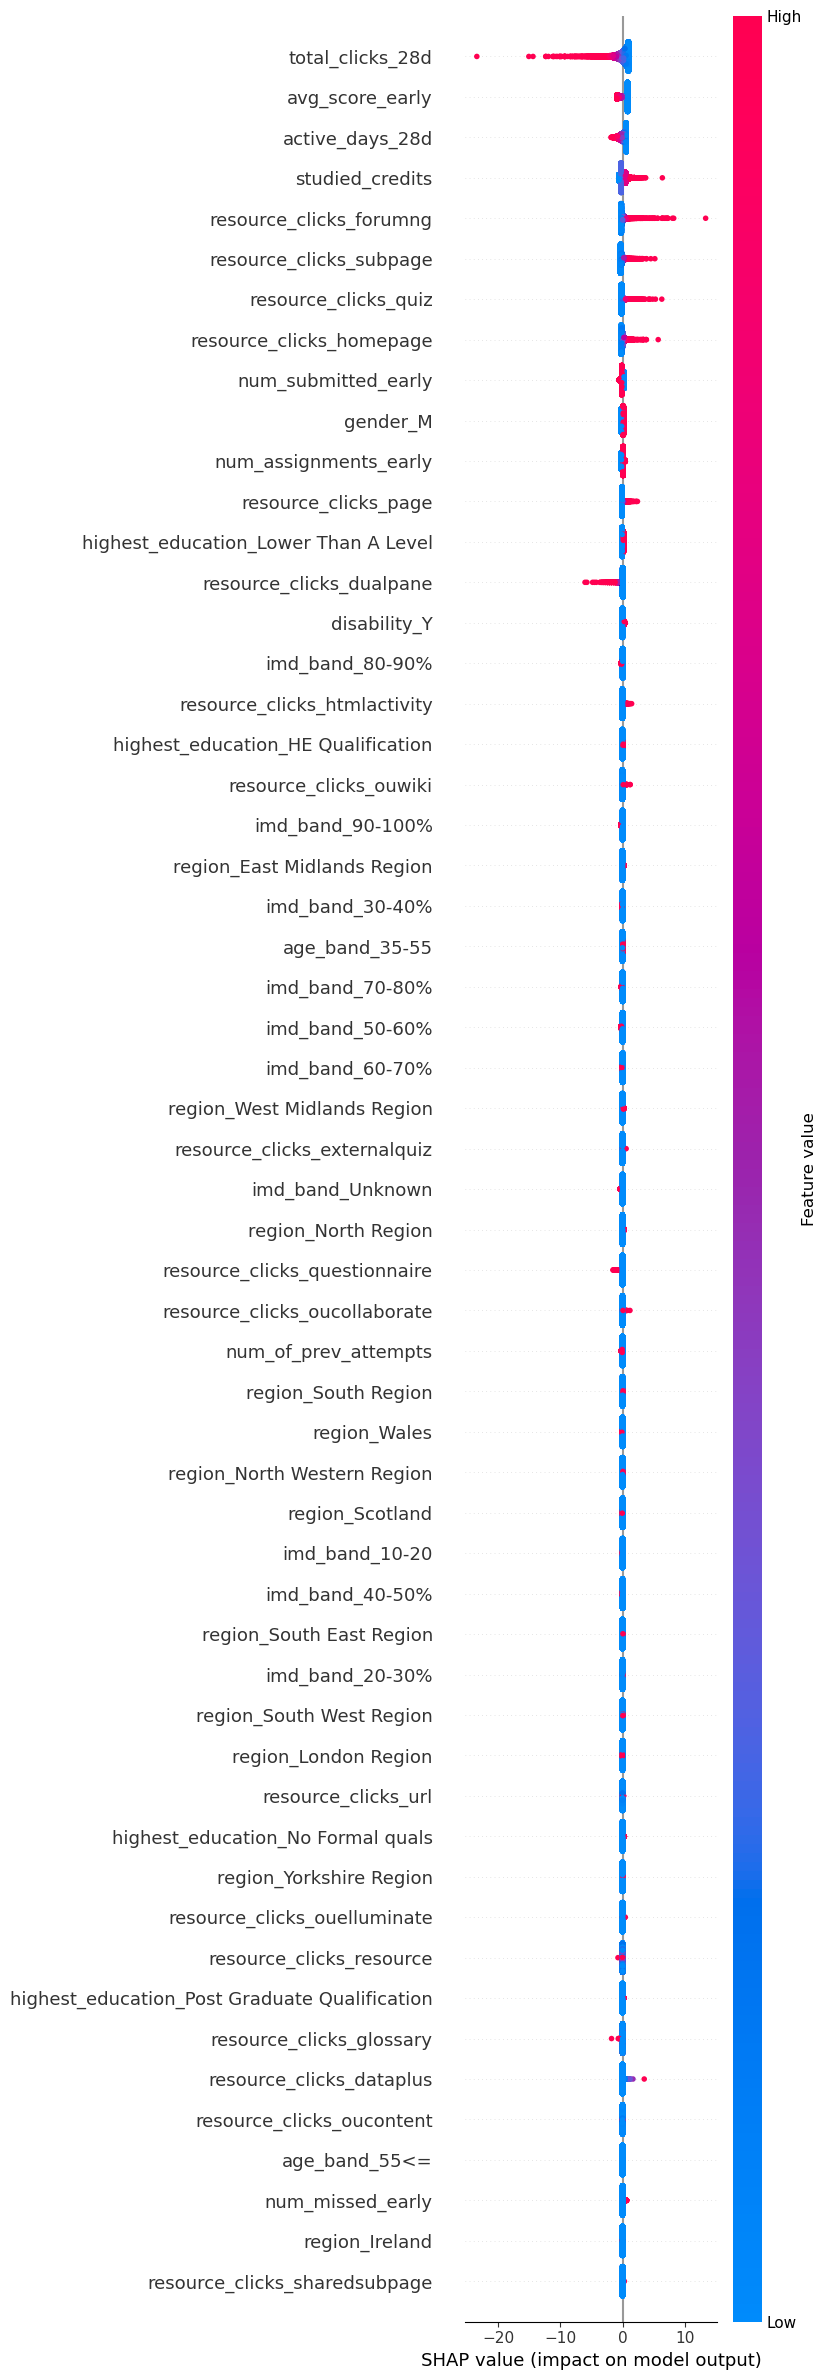

In [38]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 准备浮点型输入
X_train_clean = X_train.astype('float64')
X_test_clean  = X_test .astype('float64')

# 2. 使用 SHAP 的 Independent masker（也可以直接用 shap.LinearExplainer）
masker = shap.maskers.Independent(X_train_clean)

# 3. 创建 Explainer
explainer = shap.Explainer(logreg, masker, feature_names=X_train_clean.columns)

# 4. 计算 SHAP 值
shap_values = explainer(X_test_clean)

# 5. 抽取 values，检查维度
shap_matrix = shap_values.values      # shape 应该是 (n_samples, n_features)
print("SHAP matrix shape:", shap_matrix.shape)

# 6. 绘制完整的 summary plot
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_matrix,
    X_test_clean,
    plot_type="dot",
    max_display=56      # ← 显示全部 56 个特征
)


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Create Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  
)

# Train model
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]  # for AUC

y_pred_rf = rf.predict(X_test)
y_proba_rf = y_proba  

# Evaluation metrics
print("🌲 Random Forest - Test Set Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


🌲 Random Forest - Test Set Results:
Accuracy: 0.8016976886888935
F1-score: 0.6540588760035683
AUC: 0.8165536588982288

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      6731
           1       0.72      0.60      0.65      3047

    accuracy                           0.80      9778
   macro avg       0.77      0.75      0.76      9778
weighted avg       0.80      0.80      0.80      9778

Confusion Matrix:
[[6006  725]
 [1214 1833]]


In [27]:
print(type(shap_values))                # 应该是 list
print(len(shap_values))                 # 应该是 2（对于二分类）
print(type(shap_values[1]))             # 应该是 numpy.ndarray
print("shap_values[1] shape:", shap_values[1].shape)  # 应该是 (9778, 56)


<class 'numpy.ndarray'>
9778
<class 'numpy.ndarray'>
shap_values[1] shape: (56, 2)


In [31]:
import shap

# 🧠 确保 X_test 是 DataFrame（不是 np.array）
print("X_test type:", type(X_test))
print("X_test shape:", X_test.shape)

# ✅ 正确使用 TreeExplainer
explainer = shap.TreeExplainer(rf)

# ✅ 计算 shap 值（返回 list）
shap_values = explainer.shap_values(X_test)

# 🧪 打印 shap_values[1] 的形状
print("shap_values[1] type:", type(shap_values[1]))
print("shap_values[1] shape:", shap_values[1].shape)


X_test type: <class 'pandas.core.frame.DataFrame'>
X_test shape: (9778, 56)
shap_values[1] type: <class 'numpy.ndarray'>
shap_values[1] shape: (56, 2)


100%|===================| 19526/19556 [05:21<00:00]        

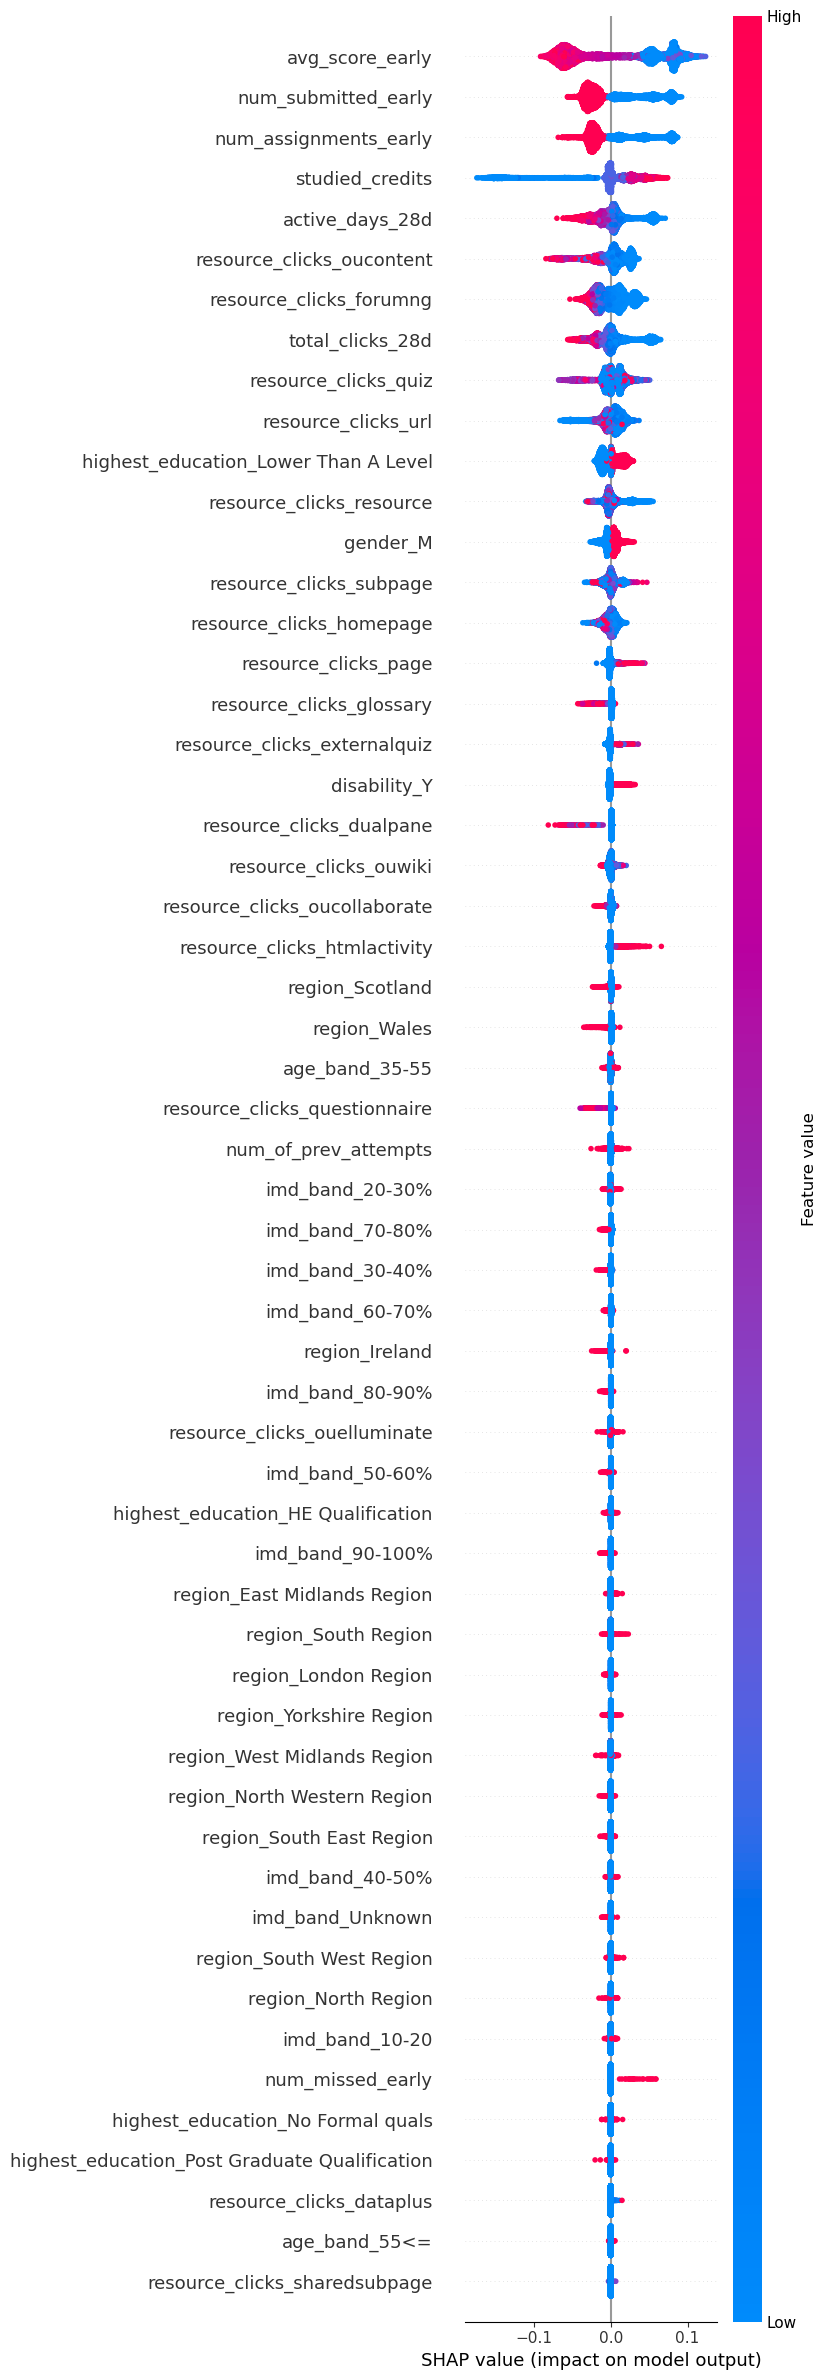

In [37]:
import shap
import pandas as pd

# 1. 确保输入
X_test_float = pd.DataFrame(X_test, columns=X_test.columns).astype(float)

# 2. 用通用接口解释器
explainer = shap.Explainer(rf, X_test_float)

# 3. 计算 SHAP explanation
shap_expl = explainer(X_test_float)

# 4. 切片：取 class=1 的 SHAP 值
#    shap_expl.values.shape == (9778, 56, 2)
shap_mat_class1 = shap_expl.values[:, :, 1]  # 得到 (9778, 56)

# 5. 绘制 summary plot（主效应，和 LogReg 完全一致的风格）
shap.summary_plot(
    shap_mat_class1,
    X_test_float,
    plot_type="dot",
    max_display=56  # 显示所有特征
)


In [41]:
# 清洗列名非法字符（加 r 解决 SyntaxWarning）
X_train.columns = X_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
X_test.columns = X_test.columns.str.replace(r'[\[\]<>]', '', regex=True)

# 创建模型（去掉 use_label_encoder）
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# 训练
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 模型预测
y_pred_xgb = xgb_model.predict(X_test)

# 评估
print("📊 Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\n🔍 Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


📊 Accuracy: 0.8008795254653304

🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.86      6731
           1       0.75      0.55      0.63      3047

    accuracy                           0.80      9778
   macro avg       0.78      0.73      0.75      9778
weighted avg       0.79      0.80      0.79      9778

📉 Confusion Matrix:
 [[6164  567]
 [1380 1667]]


 99%|===================| 9695/9778 [00:28<00:00]        

SHAP matrix shape: (9778, 56)


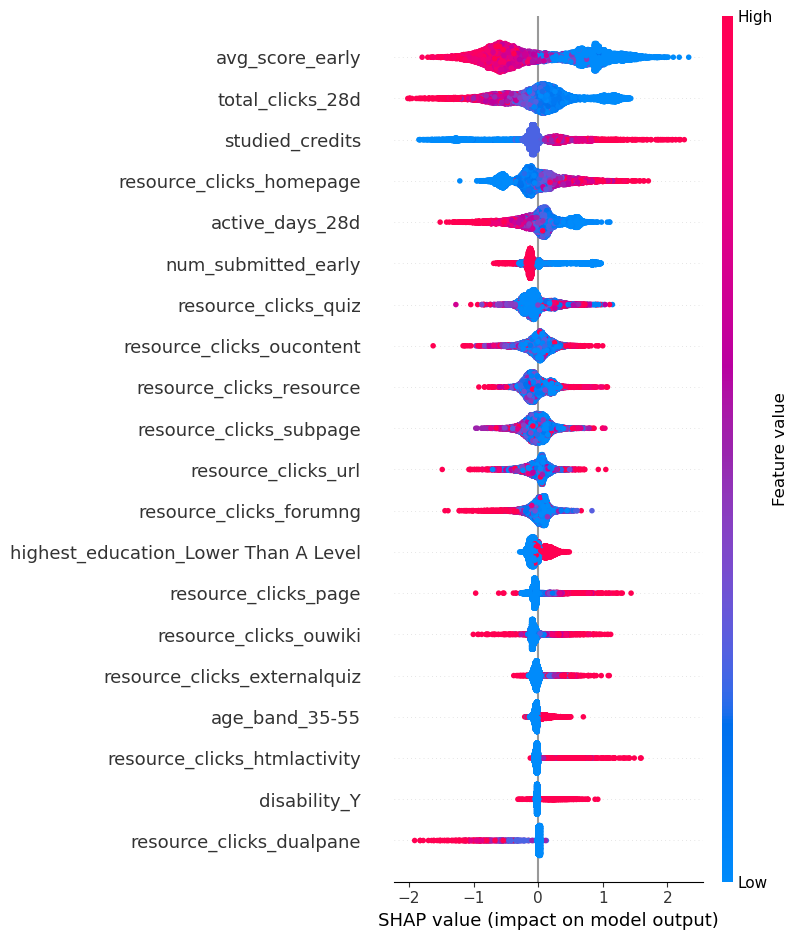

In [43]:
import shap

# 类型转换，防止 dtype 报错
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# 使用 SHAP TreeExplainer
explainer = shap.Explainer(xgb_model, X_train_float)

# 计算 SHAP 值
shap_values = explainer(X_test_float)

# 显示 SHAP 值矩阵形状
print("SHAP matrix shape:", shap_values.values.shape)

# 画 summary plot（默认是 bar + beeswarm 形式）
shap.summary_plot(shap_values, X_test_float)


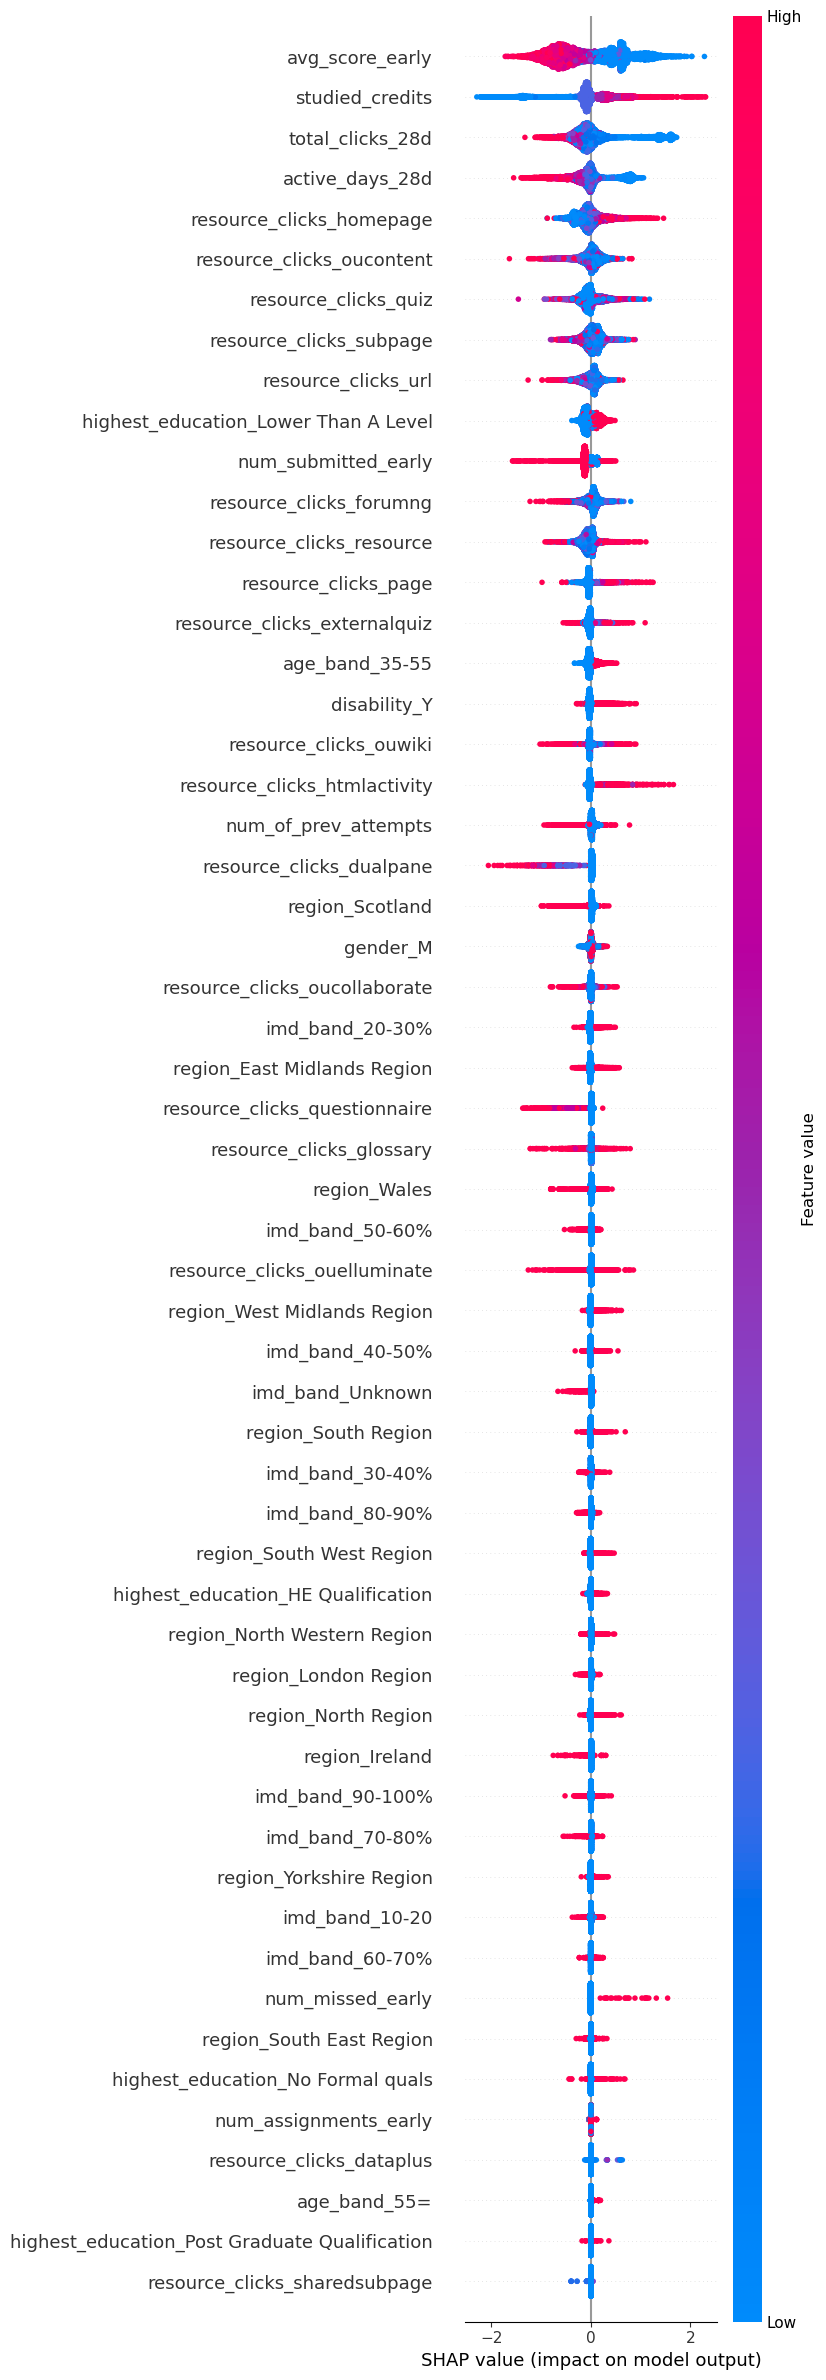

In [44]:
import shap
import matplotlib.pyplot as plt

# 1️⃣ 创建 TreeExplainer（如果还未创建）
explainer = shap.Explainer(xgb_model)

# 2️⃣ 计算 SHAP 值
shap_values = explainer(X_test)

# 3️⃣ 绘制 summary plot（展示全部 56 个特征）
shap.summary_plot(shap_values.values, X_test, max_display=56)


In [51]:
from sklearn.metrics import classification_report

# Logistic Regression 原始
report_logreg = classification_report(y_test, y_pred, output_dict=True)

# Logistic Regression with SMOTE
report_logreg_smote = classification_report(y_test, y_pred_smote, output_dict=True)

# Random Forest
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# XGBoost
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)


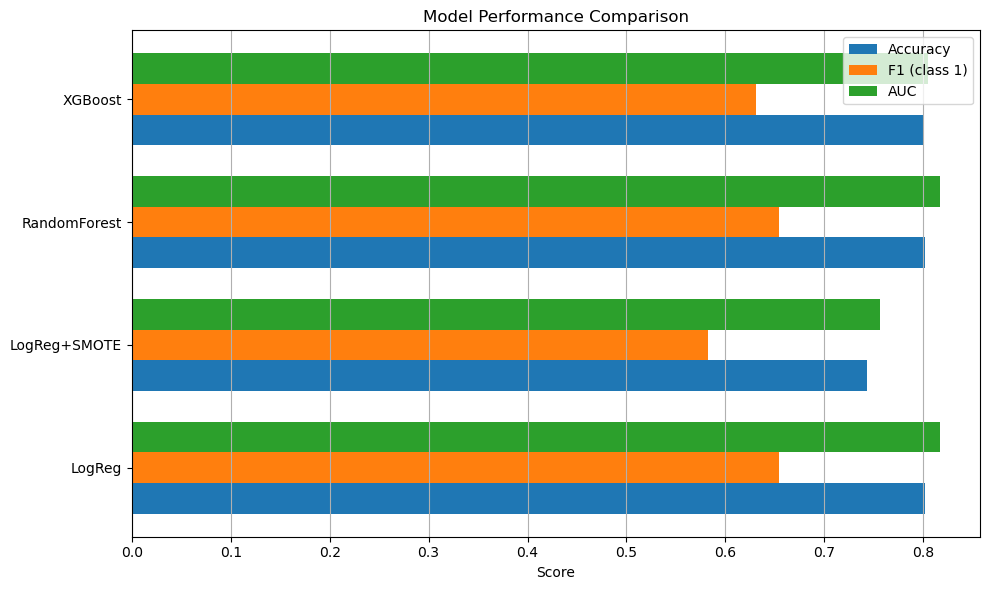

In [53]:
import matplotlib.pyplot as plt
import numpy as np

y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 汇总所有模型指标
model_names = ['LogReg', 'LogReg+SMOTE', 'RandomForest', 'XGBoost']

accuracy = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_smote),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb),
]

f1_class1 = [
    classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],
    classification_report(y_test, y_pred_smote, output_dict=True)['1']['f1-score'],
    classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'],
    classification_report(y_test, y_pred_xgb, output_dict=True)['1']['f1-score'],
]

auc_score = [
    roc_auc_score(y_test, y_proba),
    roc_auc_score(y_test, y_proba_smote),
    roc_auc_score(y_test, y_proba_rf),
    roc_auc_score(y_test, y_proba_xgb),
]

# 可视化
bar_width = 0.25
x = np.arange(len(model_names))

plt.figure(figsize=(10, 6))
plt.barh(x - bar_width, accuracy, bar_width, label='Accuracy')
plt.barh(x, f1_class1, bar_width, label='F1 (class 1)')
plt.barh(x + bar_width, auc_score, bar_width, label='AUC')

plt.yticks(x, model_names)
plt.xlabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [55]:
import shap

X_train_clean = X_train.astype('float64')
X_test_clean = X_test.astype('float64')

masker = shap.maskers.Independent(X_train_clean)
explainer_logreg = shap.Explainer(logreg, masker, feature_names=X_train.columns)
shap_values_logreg = explainer_logreg(X_test_clean)

explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)

explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ 修复 Random Forest 的 shap_values（多类 --> 二类中的 class 1）
shap_values_rf_fixed = shap_values_rf[:, :, 1]  # shape (9778, 56)

# 2️⃣ 各模型的 SHAP 平均绝对值（每个特征的重要性）
shap_imp_logreg = np.abs(shap_values_logreg.values).mean(axis=0).flatten()  # (56,)
shap_imp_rf     = np.abs(shap_values_rf_fixed).mean(axis=0).flatten()       # (56,)
shap_imp_xgb    = np.abs(shap_values_xgb).mean(axis=0).flatten()            # (56,)

# 3️⃣ 合并为 DataFrame，方便后续排序 & 可视化
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Logistic Regression': shap_imp_logreg,
    'Random Forest': shap_imp_rf,
    'XGBoost': shap_imp_xgb
})

# 4️⃣ 获取 Top 20 特征（按三模型平均重要性排序）
shap_df['Mean_Importance'] = shap_df[['Logistic Regression', 'Random Forest', 'XGBoost']].mean(axis=1)
top_features = shap_df.sort_values('Mean_Importance', ascending=False).head(20)


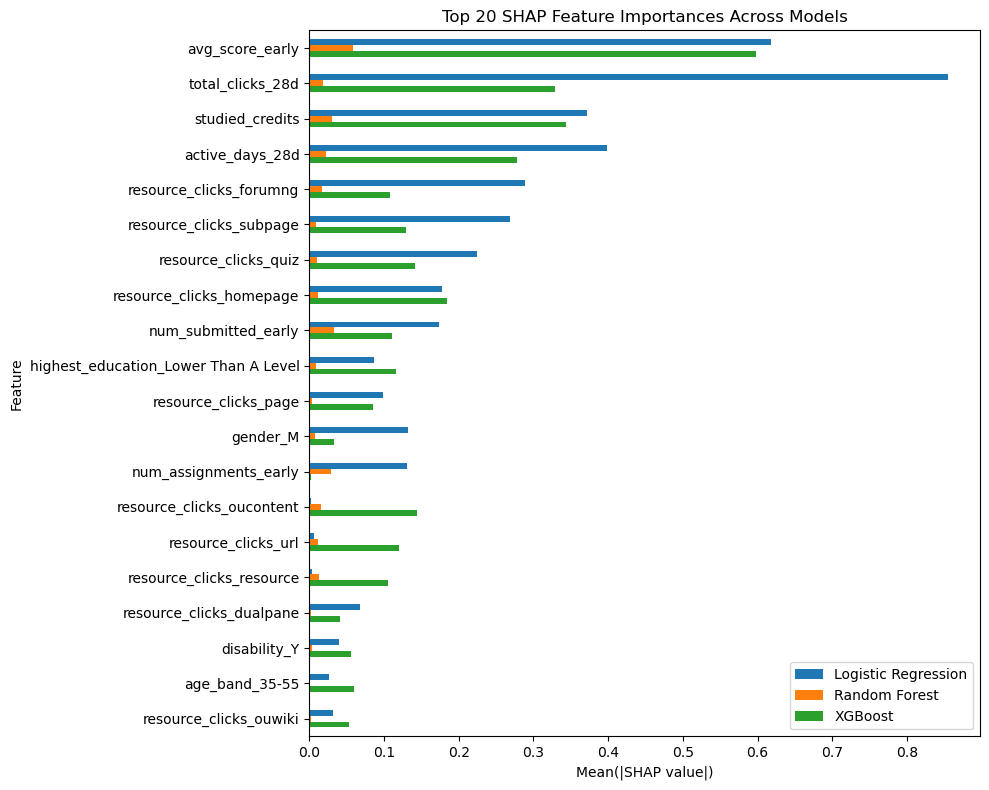

In [59]:
# 5️⃣ 绘图：三个模型的 SHAP 对比条形图
top_features.set_index('Feature')[['Logistic Regression', 'Random Forest', 'XGBoost']].plot(
    kind='barh', figsize=(10, 8))

plt.title('Top 20 SHAP Feature Importances Across Models')
plt.xlabel('Mean(|SHAP value|)')
plt.gca().invert_yaxis()  # 特征从上到下排
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

# 加载 studentInfo.csv（注意使用正确路径）
student_info = pd.read_csv("G:/DSP DATA SET/studentInfo.csv")

# 查看前几行
student_info.head()


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [11]:
# 对所有分类列做 one-hot 编码
student_info_encoded = pd.get_dummies(student_info, columns=[
    'code_module', 'code_presentation', 'gender', 'region',
    'highest_education', 'age_band', 'disability'
])

# 打印结果看看
print("✅ Encoded shape:", student_info_encoded.shape)
student_info_encoded.head()


✅ Encoded shape: (32593, 41)


,id_student,imd_band,num_of_prev_attempts,studied_credits,final_result,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,...,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y
0,11391,90-100%,0,240,Pass,True,False,False,False,False,...,False,True,False,False,False,False,False,True,True,False
1,28400,20-30%,0,60,Pass,True,False,False,False,False,...,False,True,False,False,False,False,True,False,True,False
2,30268,30-40%,0,60,Withdrawn,True,False,False,False,False,...,True,False,False,False,False,False,True,False,False,True
3,31604,50-60%,0,60,Pass,True,False,False,False,False,...,True,False,False,False,False,False,True,False,True,False
4,32885,50-60%,0,60,Pass,True,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False


In [12]:
# 读取 VLE 数据
vle = pd.read_csv("G:/DSP DATA SET/vle.csv")
student_vle = pd.read_csv("G:/DSP DATA SET/studentVle.csv")

# 合并资源类型
vle_merged = student_vle.merge(vle[['id_site', 'activity_type']], on='id_site', how='left')

# 筛选前 28 天的数据
vle_28 = vle_merged[vle_merged['date'] <= 28].copy()

# 总点击量
click_total = vle_28.groupby('id_student')['sum_click'].sum().reset_index().rename(columns={'sum_click': 'total_clicks_28d'})

# 按资源类型聚合点击量
click_by_type = vle_28.groupby(['id_student', 'activity_type'])['sum_click'].sum().unstack(fill_value=0).add_prefix('resource_clicks_').reset_index()

# 合并为 click_features
click_features = click_total.merge(click_by_type, on='id_student', how='left')

# 检查结果
print("✅ click_features shape:", click_features.shape)
click_features.head()


✅ click_features shape: (25707, 20)


,id_student,total_clicks_28d,resource_clicks_dataplus,resource_clicks_dualpane,resource_clicks_externalquiz,resource_clicks_forumng,resource_clicks_glossary,resource_clicks_homepage,resource_clicks_htmlactivity,resource_clicks_oucollaborate,resource_clicks_oucontent,resource_clicks_ouelluminate,resource_clicks_ouwiki,resource_clicks_page,resource_clicks_questionnaire,resource_clicks_quiz,resource_clicks_resource,resource_clicks_sharedsubpage,resource_clicks_subpage,resource_clicks_url
0,6516,826,0,0,0,170,0,133,0,0,439,0,0,0,0,0,15,0,38,31
1,8462,385,0,0,3,28,0,102,0,8,44,0,1,0,0,0,31,0,151,17
2,11391,401,0,0,0,55,0,42,0,0,273,0,0,0,0,0,9,0,21,1
3,23629,53,0,0,0,32,0,14,0,0,0,0,0,0,0,0,2,0,5,0
4,23698,365,0,0,0,27,0,46,0,0,3,0,0,0,0,245,6,0,34,4


In [13]:
import pandas as pd

# 加载数据
assessments = pd.read_csv("G:/DSP DATA SET/assessments.csv")
student_assessment = pd.read_csv("G:/DSP DATA SET/studentAssessment.csv")

# 合并两个表（添加 assessment 类型信息）
df_assess = student_assessment.merge(assessments[['id_assessment', 'assessment_type', 'date']],
                                     on='id_assessment', how='left')

# 仅保留课程前 28 天的作业记录
df_assess_28 = df_assess[df_assess['date'] <= 28].copy()

# 构建特征：
assignment_features = df_assess_28.groupby('id_student').agg(
    num_assignments_early=('id_assessment', 'count'),
    num_submitted_early=('date_submitted', 'count'),
    avg_score_early=('score', 'mean')
).reset_index()

print("✅ assignment_features shape:", assignment_features.shape)
assignment_features.head()


✅ assignment_features shape: (19546, 4)


,id_student,num_assignments_early,num_submitted_early,avg_score_early
0,6516,1,1,60.0
1,8462,2,2,93.0
2,11391,1,1,78.0
3,23629,1,1,67.0
4,23698,1,1,78.0


In [14]:
# 首先确保 target 是 0/1
student_info_encoded['target'] = student_info_encoded['final_result'].apply(lambda x: 1 if x in ['Withdrawn', 'Fail'] else 0)

# 删除原始标签列
student_info_encoded = student_info_encoded.drop(columns=['final_result'])

# 三表合并（左连接，保留 student_info 中的所有学生）
df_final = student_info_encoded.merge(click_features, on='id_student', how='left') \
                               .merge(assignment_features, on='id_student', how='left')

# 缺失值填充
df_final.fillna(0, inplace=True)

print("✅ df_final shape:", df_final.shape)
df_final.head()


✅ df_final shape: (32593, 63)


,id_student,imd_band,num_of_prev_attempts,studied_credits,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,...,resource_clicks_page,resource_clicks_questionnaire,resource_clicks_quiz,resource_clicks_resource,resource_clicks_sharedsubpage,resource_clicks_subpage,resource_clicks_url,num_assignments_early,num_submitted_early,avg_score_early
0,11391,90-100%,0,240,True,False,False,False,False,False,...,0.0,0.0,0.0,9.0,0.0,21.0,1.0,1.0,1.0,78.0
1,28400,20-30%,0,60,True,False,False,False,False,False,...,0.0,0.0,0.0,5.0,0.0,59.0,30.0,1.0,1.0,70.0
2,30268,30-40%,0,60,True,False,False,False,False,False,...,0.0,0.0,0.0,4.0,0.0,22.0,4.0,0.0,0.0,0.0
3,31604,50-60%,0,60,True,False,False,False,False,False,...,0.0,0.0,0.0,10.0,0.0,52.0,17.0,1.0,1.0,72.0
4,32885,50-60%,0,60,True,False,False,False,False,False,...,0.0,0.0,0.0,7.0,0.0,28.0,6.0,1.0,1.0,69.0


In [46]:
from sklearn.model_selection import GroupShuffleSplit

# ✅ 保留 id_student 分组信息
X = df_final.drop(columns=['target'])  # 暂不删 id_student，后面用于分组
y = df_final['target']
groups = df_final['id_student']

# ✅ 创建 GroupShuffleSplit 实例
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# ✅ 执行划分
for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx].drop(columns=['id_student']), X.iloc[test_idx].drop(columns=['id_student'])
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# ✅ 查看划分结果
print(f"✅ X_train shape: {X_train.shape}, y_train mean: {y_train.mean():.4f}")
print(f"✅ X_test shape: {X_test.shape}, y_test mean: {y_test.mean():.4f}")


✅ X_train shape: (22842, 58), y_train mean: 0.3144
✅ X_test shape: (9751, 58), y_test mean: 0.3051


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 1️⃣ 初始化模型
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# 2️⃣ 参数网格
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']  # 注意：liblinear 支持 L1/L2
}

# 3️⃣ 交叉验证设置
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4️⃣ GridSearchCV 实例
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1',       # 以 F1-score 评估，专注于退学识别效果
    cv=cv,
    n_jobs=-1,
    verbose=1
)


In [48]:
# 查看 object 类型列（通常是字符串列）
X_train.select_dtypes(include='object').nunique()


code_module          7
code_presentation    4
dtype: int64

In [49]:
# 将所有 object 类型列做 OneHot 编码
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# 对齐测试集和训练集列（防止列不一致）
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


In [50]:
# 转换为 float64 类型
X_train_clean = X_train_encoded.astype('float64')
X_test_clean = X_test_encoded.astype('float64')


In [51]:
grid_search.fit(X_train_clean, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='f1', verbose=1)

In [52]:
# 输出最佳参数组合和对应得分
print("✅ Best parameters:", grid_search.best_params_)
print("📊 Best F1 score (CV):", grid_search.best_score_)

# 用最佳模型在测试集上评估
best_logreg = grid_search.best_estimator_

y_pred = best_logreg.predict(X_test_clean)
y_proba = best_logreg.predict_proba(X_test_clean)[:, 1]

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

print("\n📊 Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅ Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
📊 Best F1 score (CV): 0.6620419709963437

📊 Test Set Evaluation:
Accuracy: 0.7869962055173828
F1 Score: 0.6639702313541498
AUC: 0.8213875963608583

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      6776
           1       0.64      0.69      0.66      2975

    accuracy                           0.79      9751
   macro avg       0.75      0.76      0.75      9751
weighted avg       0.79      0.79      0.79      9751

Confusion Matrix:
[[5622 1154]
 [ 923 2052]]


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 初始化模型
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# 参数搜索范围（适中范围）
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# GridSearch 设置
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)


In [54]:
grid_search_rf.fit(X_train_clean, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [55]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# 用最优模型预测
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_clean)
y_proba_rf = best_rf.predict_proba(X_test_clean)[:, 1]

# 评估指标
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("🎯 Random Forest Test Set Evaluation:")
print(f"Accuracy: {acc_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"AUC: {auc_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


🎯 Random Forest Test Set Evaluation:
Accuracy: 0.8147
F1 Score: 0.6736
AUC: 0.8320

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      6776
           1       0.73      0.63      0.67      2975

    accuracy                           0.81      9751
   macro avg       0.79      0.76      0.77      9751
weighted avg       0.81      0.81      0.81      9751

Confusion Matrix:
 [[6079  697]
 [1110 1865]]


In [56]:
# 清理列名：去掉中括号等非法字符
X_train_clean.columns = X_train_clean.columns.str.replace(r'[\[\]<]', '_', regex=True)
X_test_clean.columns = X_test_clean.columns.str.replace(r'[\[\]<]', '_', regex=True)

In [57]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# 初始化模型
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=1,  # 可以设置为 class imbalance 比例，但这里保持默认，后续可调
    random_state=42,
    n_jobs=-1
)

# 参数搜索空间（简单调参）
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
}

# 设置 GridSearch
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 运行调参
grid_search_xgb.fit(X_train_clean, y_train)

import joblib

# 保存最佳模型为 .pkl 文件
best_model = grid_search_xgb.best_estimator_
joblib.dump(best_model, "G:/DSP DATA SET/xgb_model.pkl")

print("✅ 最佳模型已保存为 xgb_model.pkl")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [17:42:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ 最佳模型已保存为 xgb_model.pkl


In [58]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# 获取最优模型
best_xgb = grid_search_xgb.best_estimator_

# 在测试集上预测
y_pred_xgb = best_xgb.predict(X_test_clean)
y_prob_xgb = best_xgb.predict_proba(X_test_clean)[:, 1]

# 打印评估结果
print("🎯 XGBoost Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_prob_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


🎯 XGBoost Test Set Evaluation:
Accuracy: 0.8196082453081736
F1 Score: 0.6461476564071615
AUC: 0.8324530225313267

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      6776
           1       0.80      0.54      0.65      2975

    accuracy                           0.82      9751
   macro avg       0.81      0.74      0.76      9751
weighted avg       0.82      0.82      0.81      9751

Confusion Matrix:
[[6386  390]
 [1369 1606]]


In [27]:
# 获取最优模型
best_xgb = grid_search_xgb.best_estimator_

# 预测测试集中的退学概率（第二列为 label=1 的概率）
y_proba = best_xgb.predict_proba(X_test_clean)[:, 1]


In [28]:
# 注意：你原始的 X_test_clean 是没有 student_id 的
# 我们从原始 df_final 中取出测试集对应的 id_student
id_students_test = df_final.loc[X_test_clean.index, 'id_student'].values

# 构建 Dropout Index 表格
dropout_index_df = pd.DataFrame({
    'id_student': id_students_test,
    'dropout_probability': y_proba
})

# 按概率降序排序（高风险在前）
dropout_index_df = dropout_index_df.sort_values(by='dropout_probability', ascending=False)

# 查看前 10 行
dropout_index_df.head(10)


,id_student,dropout_probability
3706,675116,0.985054
2613,108947,0.984778
3655,649523,0.984778
8559,645194,0.984008
2993,617307,0.983963
3947,364440,0.983793
3867,2619472,0.983689
2688,389680,0.983583
3857,2504694,0.983142
3743,684313,0.983122


In [29]:
dropout_index_df.to_csv(r'G:\DSP DATA SET\dropout_index_output.csv', index=False)

In [30]:
# 将课程维度数据按学生聚合
agg_dict = {col: 'max' for col in df_final.columns if col not in ['id_student', 'target']}
# 对数值型特征你也可以试试 'mean' 或 'sum'

# 将 target 设置为：如果学生在任一课程中退学，则视为该学生退学（标签为 1）
agg_dict['target'] = 'max'

df_student = df_final.groupby('id_student').agg(agg_dict).reset_index()


In [31]:
print(df_student.shape)
print(df_student['target'].value_counts())

(28785, 63)
target
1    15372
0    13413
Name: count, dtype: int64


In [32]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# ========== 第一步：对 imd_band 做 One-Hot 编码 ==========
imd_dummies = pd.get_dummies(df_student['imd_band'], prefix='imd_band', drop_first=True)
df_student = pd.concat([df_student.drop(columns=['imd_band']), imd_dummies], axis=1)

# ========== 第二步：分离特征与标签 ==========
X = df_student.drop(['id_student', 'target'], axis=1)
y = df_student['target']

# ========== 第三步：清洗列名 ==========
X.columns = [re.sub(r"[<>[\]]", "_", col) for col in X.columns]

# ========== 第四步：确保特征为 float 类型 ==========
X = X.astype(float)

# ========== 第五步：划分训练集和测试集 ==========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ========== 第六步：使用 GridSearch 最优参数训练 XGBoost ==========
best_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 200
}

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    **best_params
)

xgb_model.fit(X_train, y_train)

# ========== 第七步：预测所有学生的辍学概率 ==========
dropout_proba = xgb_model.predict_proba(X)[:, 1]
df_student['dropout_proba'] = dropout_proba

# ========== 第八步：保存预测结果 ==========
df_student[['id_student', 'dropout_proba']].to_csv(
    'G:/DSP DATA SET/student_dropout_proba.csv', index=False
)

print("✅ 模型训练完成，辍学率预测已保存到：G:/DSP DATA SET/student_dropout_proba.csv")


C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:50:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ 模型训练完成，辍学率预测已保存到：G:/DSP DATA SET/student_dropout_proba.csv


In [33]:
# ✅ 直接使用当前 df_student（包含 dropout_proba）
df_dashboard = df_student.copy()

# 🧾 检查维度和字段
print("df_dashboard 维度：", df_dashboard.shape)
print("df_dashboard 字段：", df_dashboard.columns.tolist())

# 💡 示例展示前几行
df_dashboard.head()

df_dashboard.to_csv('G:/DSP DATA SET/df_dashboard.csv', index=False)

print("✅ df_dashboard 已成功保存为：G:/DSP DATA SET/df_dashboard.csv")

df_dashboard 维度： (28785, 73)
df_dashboard 字段： ['id_student', 'num_of_prev_attempts', 'studied_credits', 'code_module_AAA', 'code_module_BBB', 'code_module_CCC', 'code_module_DDD', 'code_module_EEE', 'code_module_FFF', 'code_module_GGG', 'code_presentation_2013B', 'code_presentation_2013J', 'code_presentation_2014B', 'code_presentation_2014J', 'gender_F', 'gender_M', 'region_East Anglian Region', 'region_East Midlands Region', 'region_Ireland', 'region_London Region', 'region_North Region', 'region_North Western Region', 'region_Scotland', 'region_South East Region', 'region_South Region', 'region_South West Region', 'region_Wales', 'region_West Midlands Region', 'region_Yorkshire Region', 'highest_education_A Level or Equivalent', 'highest_education_HE Qualification', 'highest_education_Lower Than A Level', 'highest_education_No Formal quals', 'highest_education_Post Graduate Qualification', 'age_band_0-35', 'age_band_35-55', 'age_band_55<=', 'disability_N', 'disability_Y', 'total_clic

In [36]:
import pandas as pd

# Load original datasets
student_info = pd.read_csv("G:/DSP DATA SET/studentInfo.csv")
dropout_proba_df = pd.read_csv("G:/DSP DATA SET/student_dropout_proba.csv")

# Merge datasets
df_dashboard_readable = student_info.merge(dropout_proba_df, on="id_student", how="inner")

# ✅ Save with UTF-8 encoding to prevent Excel display issues
df_dashboard_readable.to_csv("G:/DSP DATA SET/df_dashboard_readable.csv", index=False, encoding='utf-8-sig')

print("✅ 正确格式的 df_dashboard_readable.csv 已保存到 G:/DSP DATA SET/")


✅ 正确格式的 df_dashboard_readable.csv 已保存到 G:/DSP DATA SET/


In [44]:
import pandas as pd

# 读取数据
df_final = pd.read_csv("G:/DSP DATA SET/df_final.csv")
dropout_proba = pd.read_csv("G:/DSP DATA SET/student_dropout_proba.csv")

# 只按 id_student 合并（假设 student_dropout_proba.csv 是聚合后的学生级别结果）
df_dashboard = pd.merge(df_final, dropout_proba, on='id_student', how='inner')

# 可选：提取 SHAP 分析的特征名
shap_feature_names = [col for col in df_final.columns if col not in ['target', 'id_student', 'code_module', 'code_presentation']]

# 保存新版本用于前端
df_dashboard.to_csv("G:/DSP DATA SET/df_dashboard_readable_with_activity.csv", index=False)

print("✅ 已保存含完整 SHAP 特征和 dropout 概率的可视化数据表")


✅ 已保存含完整 SHAP 特征和 dropout 概率的可视化数据表
